In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from sklearn.linear_model import LinearRegression
import numpy as np
import json


data_path = "data/NPD_Data_2018_2019_V3.csv"
npd_data = pd.read_csv(data_path)

In [3]:
#Remove commas from the numbers
npd_data['Units'] = npd_data['Units'].replace(',','', regex=True)

#Convert the Units column as int
npd_data['Units'] = npd_data['Units'].astype(float)

<IPython.core.display.Javascript object>


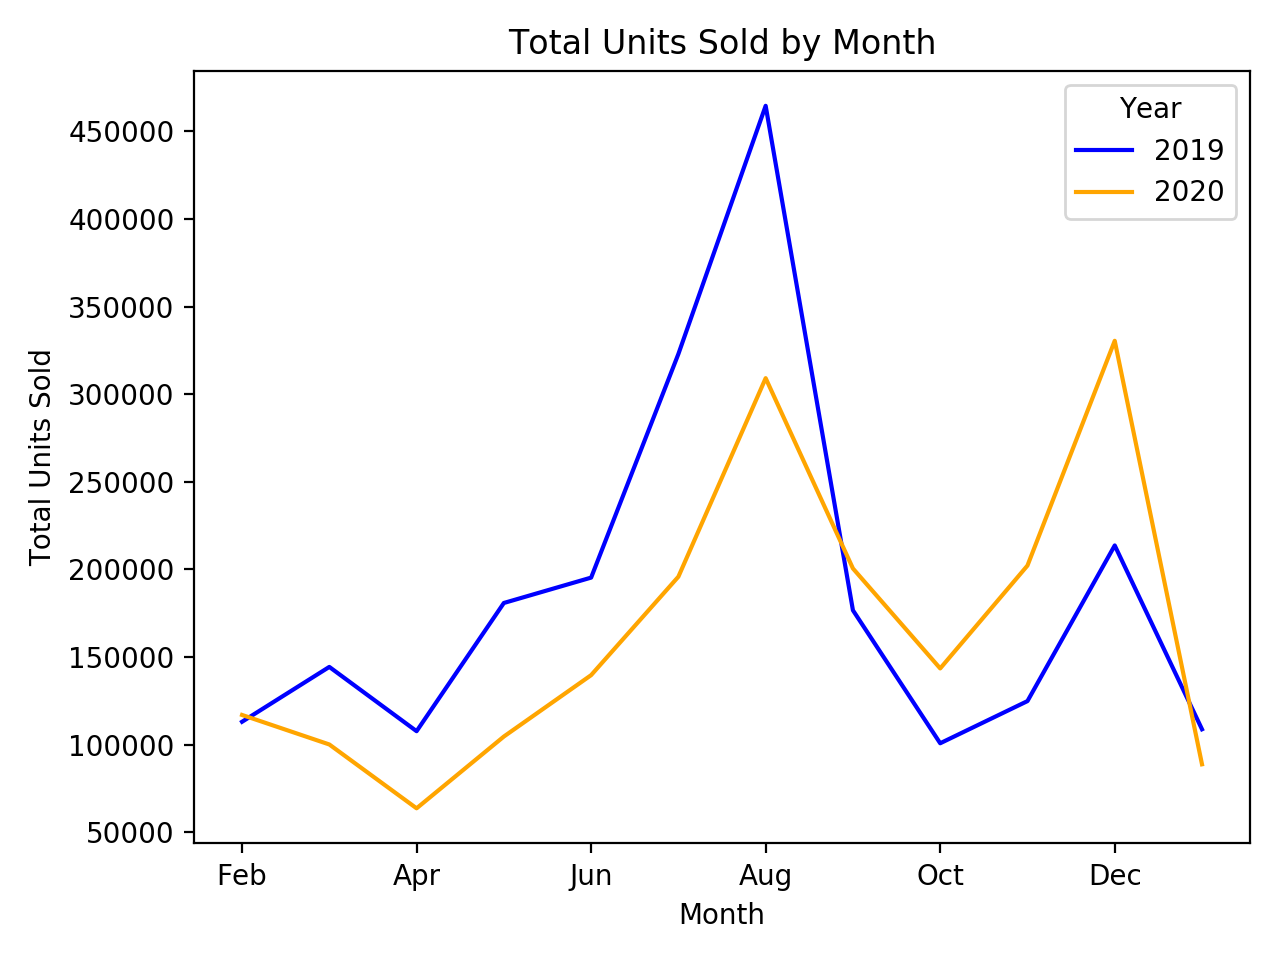

In [4]:
#Total Units of Camping Equipment Sold
#Group by year and month
month_df = npd_data.groupby(['Year', 'Month'], sort=False).sum()

#Create line chart
month_df.unstack(0).plot(kind="line", y='Units', color=['blue','orange'])
plt.title("Total Units Sold by Month")
plt.ylabel("Total Units Sold")
plt.show()
plt.tight_layout()

<IPython.core.display.Javascript object>


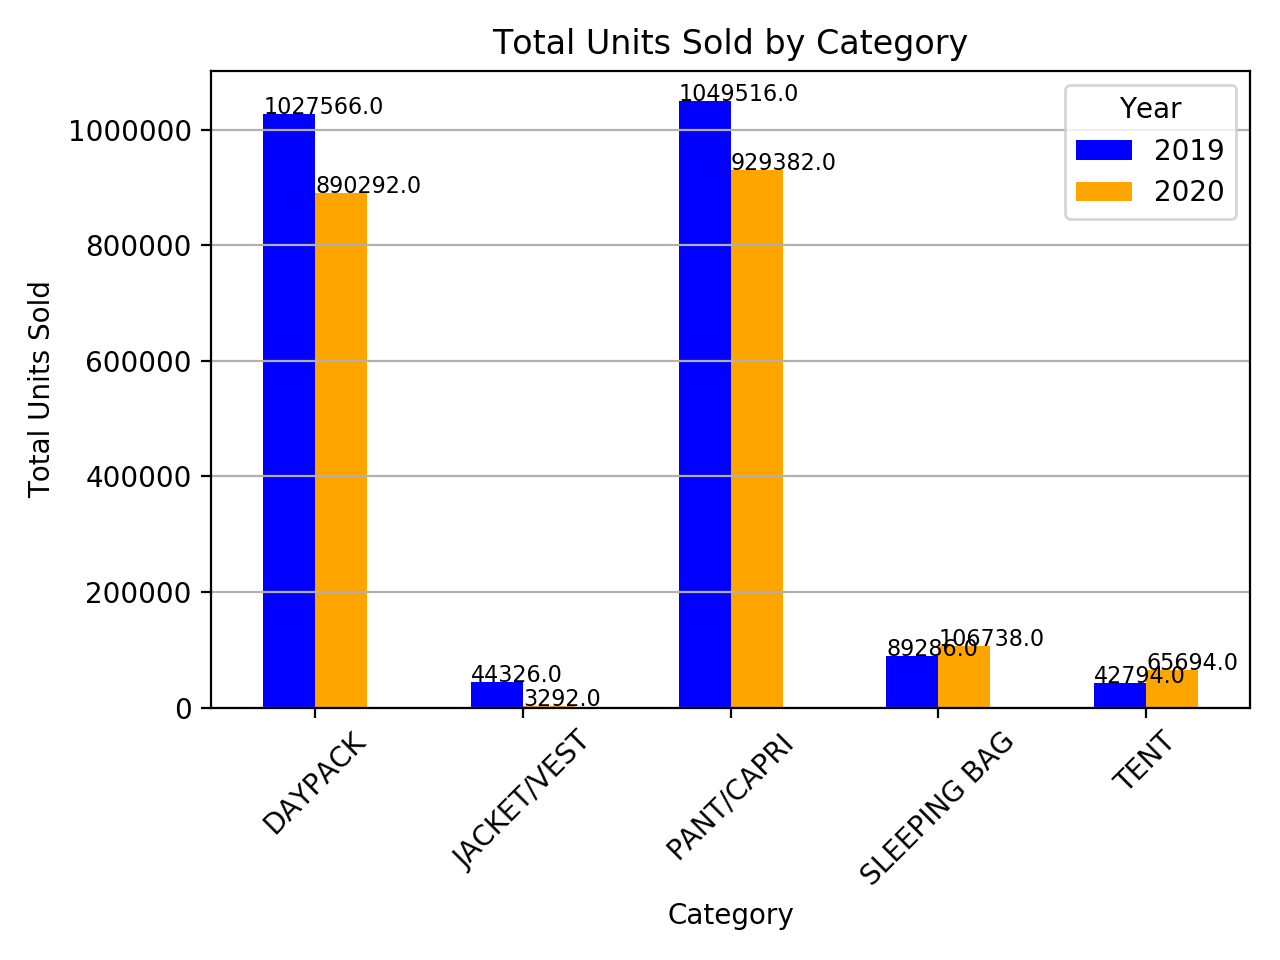

In [5]:
#Group by year and category
grp_cat = npd_data.groupby(["Year", "Category"])

#Get the sum of the units in the new groupby object
sum_by_cat = grp_cat['Units'].sum()
sum_by_cat

#Create bar plot
ax = sum_by_cat.unstack(0).plot(kind="bar", rot=45, color=["blue", "orange"])
plt.xlabel("Category")
plt.ylabel("Total Units Sold")
plt.title("Total Units Sold by Category")

#Add the total values on the chart
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), \
           str(round((i.get_height()), 2)), fontsize=8, color="black")
    
plt.grid(axis="y")
plt.show()
plt.tight_layout()

In [6]:
sum_table = sum_by_cat.unstack(0)
sum_table.columns.name = None

#Create a column for the percent change
sum_table['Percent Change'] = round((sum_table[2020] - sum_table[2019]) / sum_table[2019] * 100, 2)

#Reset index
sum_table = sum_table.reset_index()

#Get the sum of all the values
ttotal = sum_table.sum()

#Gets the total percentage change
total_change = round(((ttotal[2020] - ttotal[2019]) / ttotal[2019])*100, 2)

#Adds a new row below everything have the total values
sum_table = sum_table.append({'Category': 'TOTAL'}, ignore_index=True)

#Adds the totals in the dataframe
sum_table.iloc[5,1] = ttotal[2019]
sum_table.iloc[5,2] = ttotal[2020]
sum_table.iloc[5,3] = total_change

#Set the index to be category to get rid of index number
sum_table = sum_table.set_index('Category')
sum_table

,2019,2020,Percent Change
Category,,,
DAYPACK,1027566.0,890292.0,-13.36
JACKET/VEST,44326.0,3292.0,-92.57
PANT/CAPRI,1049516.0,929382.0,-11.45
SLEEPING BAG,89286.0,106738.0,19.55
TENT,42794.0,65694.0,53.51
TOTAL,2253488.0,1995398.0,-11.45
